# import necessary dependencies

In [7]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost keras

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 3.7 MB/s eta 0:00:40
   ---------------------------------------- 1.8/150.0 MB 4.4 MB/s eta 0:00:34
    --------------------------------------- 3.1/150.0 MB 4.9 MB/s eta 0:00:31
   - -------------------------------------- 4.2/150.0 MB 4.9 MB/s eta 0:00:30
   - -------------------------------------- 5.5/150.0 MB 5.1 MB/s eta 0:00:29
   - -------------------------------------- 7.1/150.0 MB 5.4 MB/s eta 0:00:27
   -- ------------------------------------- 7.9/150.0 MB 5.1 MB/s eta 0:00:28
   -- ------------------------------------- 8.4/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 10.0/150.0 MB 5.1 MB/s eta 0:00:28
   -- ------------------------------------- 11.0/150.0 MB 5.1 MB/s eta 0:00:28
   --- ------------------------------------ 12.6/150.0 MB 5.3 MB/s eta 0:00:

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

import xgboost as xgb
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Reshape


# Loaad data

In [11]:
df = pd.read_csv("C:\\Users\\akhil\\Downloads\\creditcard.csv")

In [13]:
df.shape

(284807, 31)

In [15]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
df.describe

<bound method NDFrame.describe of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599

# Data Preprocessing

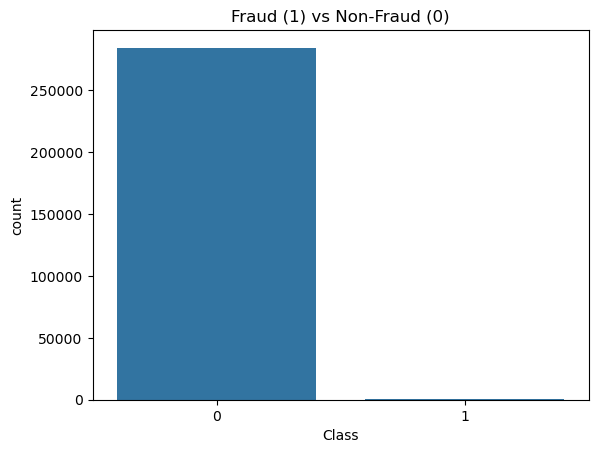

In [22]:
# Check class balance
sns.countplot(data=df, x='Class')
plt.title("Fraud (1) vs Non-Fraud (0)")
plt.show()

# Drop 'Time' column, scale 'Amount'
df.drop("Time", axis=1, inplace=True)
df["Amount"] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))


# Train-Test Split

In [26]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle Imbalance Using SMOTE

In [29]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Balanced dataset shape:", X_res.shape)

Balanced dataset shape: (454902, 29)


# Reshape for LSTM

In [32]:
# LSTM requires 3D input
X_lstm = np.reshape(X_res.values, (X_res.shape[0], 1, X_res.shape[1]))

# LSTM Model for Feature Learning

In [35]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_res.shape[1]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(X_res.shape[1]))  # Output feature representation

model.compile(loss='mse', optimizer='adam')
model.fit(X_lstm, X_res.values, epochs=5, batch_size=64, verbose=1)

# Extract LSTM features
features = model.predict(X_lstm)


C:\Users\akhil\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 1.5350
Epoch 2/5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 0.3298
Epoch 3/5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step - loss: 0.2783
Epoch 4/5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.2543
Epoch 5/5
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.2276
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step


# Train XGBoost on LSTM Features

In [40]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(features, y_res)

# Prepare test data
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_test_lstm_features = model.predict(X_test_reshaped)

# Predict
y_pred = xgb_model.predict(X_test_lstm_features)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


# Evaluation

In [42]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_score)

[[56808    56]
 [   15    83]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.60      0.85      0.70        98

    accuracy                           1.00     56962
   macro avg       0.80      0.92      0.85     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.922976984828822


# Visualization

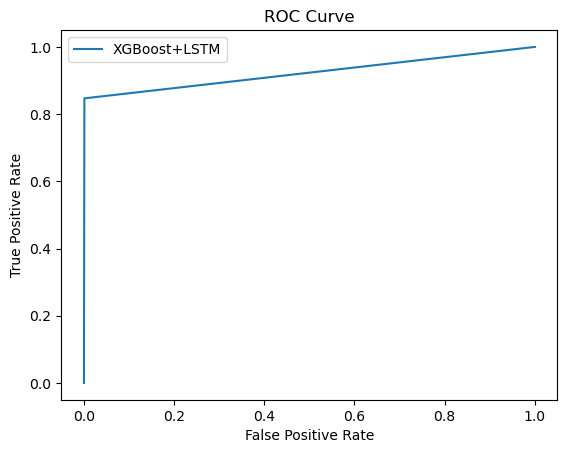

In [44]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='XGBoost+LSTM')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()